# Breast Cancer Detection

## Motivation

Features of biopsied breast cells are provided where it is benign (not harmful) or malignant (cancerous). Goal is to develop a model that can predict whether a given biopsied breast cell is benign or malignant.

Questions:

What features of a cell are the largest drivers of malignancy? 

Build a model that predicts whether a given biopsied breast cell is benign or malignant.
What features drive your false positive rate for your model you derived above, what features drive your false negative rate? 

How would a physician use your product?

There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?


## Initialize libraries and basic setup for graphics

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

## Exploratory Data Analysis

### Data cleaning

In [3]:
df_bc = pd.read_csv("./data/breast-cancer-wisconsin.txt", delimiter=",")

In [4]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15855 non-null int64
ID                             15855 non-null int64
Clump Thickness                15855 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


Except first three columns, other are object. This indicates they contain data types that are not integer. They are in fact an error. Furthermore, errorneous data is monitored, but their proportion is less 0.5%. __Any numeric data that is not in given interval is considered as error__. Therefore, instead of imputing with mean/median, these examples were removed.    

In [24]:
ts_valid_range     = [str(i) for i in range(1,11)]
ts_valid_int_range = [int(i) for i in range(1,11)]

for col in df_bc.columns:
    if  not (col.strip()=="ID" or col.strip() == "Index"):
        unique_data = df_bc[col].value_counts(normalize=True)
        data = unique_data.keys().to_list()
        freq = np.array(unique_data.to_list())
        
        if col == 'Clump Thickness': 
            print(col, ":",[(i, "%0.2f" %f) for i, f in zip(data, freq) if not i in ts_valid_int_range and f>0.5])
        else: 
            print(col, ":",[(i, "%0.2f" %f) for i, f in zip(data, freq) if not i in ts_valid_range and f>0.5])    

Clump Thickness : []
Uniformity of Cell Size : []
Uniformity of Cell Shape : []
Marginal Adhesion : []
Single Epithelial Cell Size : []
Bare Nuclei : []
Bland Chromatin : []
Normal Nucleoli : []
Mitoses : []
Class : []


Due to the presence of different types of text in data, first, all these error were converted by np.nan. Afterward, these are dropped. After removing invalid inputs, each column is converted into integer data types. 

In [25]:
cols = df_bc.columns
for i in cols[2:]:
    if i == "Clump Thickness":
        df_bc[i]= df_bc[i].apply(lambda x: int(x) if x in ts_valid_int_range else np.nan)
    else:
        df_bc[i]= df_bc[i].apply(lambda x: int(x) if x in ts_valid_range else np.nan)

df_cleaned_bc = df_bc.dropna(axis=0)
# Convert to int
for i in cols[2:]:
    df_cleaned_bc[i] = df_cleaned_bc[i].astype(int)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
df_cleaned_bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15604 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15604 non-null int64
ID                             15604 non-null int64
Clump Thickness                15604 non-null int64
Uniformity of Cell Size        15604 non-null int64
Uniformity of Cell Shape       15604 non-null int64
Marginal Adhesion              15604 non-null int64
Single Epithelial Cell Size    15604 non-null int64
Bare Nuclei                    15604 non-null int64
Bland Chromatin                15604 non-null int64
Normal Nucleoli                15604 non-null int64
Mitoses                        15604 non-null int64
Class                          15604 non-null int64
dtypes: int64(12)
memory usage: 1.5 MB


In [27]:
df_cleaned_bc.describe()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,15604.000000,1.560400e+04,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000
mean,7928.549859,1.033604e+06,7.587413,6.896950,5.624968,5.033389,4.221097,6.466675,4.614586,4.972315,1.663932,3.943348
std,4575.908481,2.761056e+05,2.164067,2.466078,2.131174,2.910681,2.096365,3.221766,1.896105,2.817212,1.502325,0.331816
min,0.000000,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,3969.750000,1.076352e+06,7.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,4.000000
50%,7927.500000,1.111249e+06,8.000000,6.000000,5.000000,4.000000,4.000000,8.000000,4.000000,5.000000,1.000000,4.000000
75%,11890.250000,1.198641e+06,10.000000,10.000000,7.000000,7.000000,4.000000,10.000000,7.000000,8.000000,2.000000,4.000000
max,15854.000000,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


### Distribution of features 
After data cleaning, feature analysis is carried out in which statistical analysis is done to identify the distribution of features. There are two classes and box plot corresponding showed the distribution of their features. Distribution of benign (not harmful) is represented by 2 (upper box plot) whereas malignant (cancerous) labelled with 4 is shown in lower graph.  

* Although benign class has very low values for all features except clump thickness and bland chromatin, they are also less than corresponding values from malignant class.
* Comparing the distribution of features associated with two classes, it is clear that they follow different distribution. 
* __All cell properties except mitoses are potential drivers for malignant__.

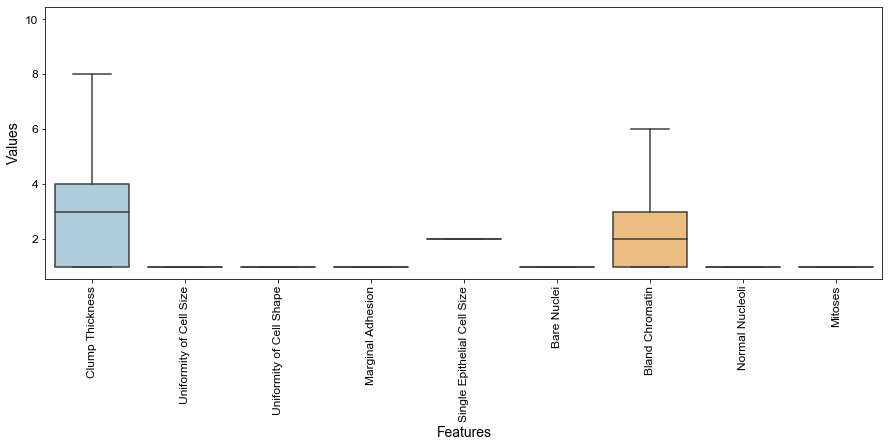

In [28]:
def plot_box_based_class(target=2):
    cols = df_cleaned_bc.columns
    f, ax = plt.subplots(figsize=(15, 5))
    pal = sns.color_palette('Paired')
    df_box_data_benign = df_cleaned_bc[df_cleaned_bc['Class']==target]
    df_box_data_benign = pd.melt(df_box_data_benign[cols[2:]], "Class", var_name="Features", value_name="Values")
    ax = sns.boxplot(x='Features', y='Values', data=df_box_data_benign, palette=pal, fliersize=0)
    # sns.stripplot(x='group', y='value', data=df_cleaned_bc, color="orange", jitter=0.2, size=2.5)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()
plot_box_based_class(2)

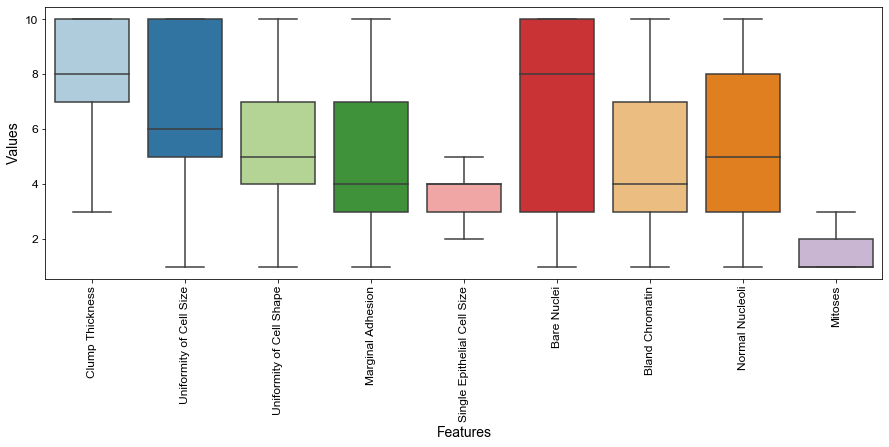

In [29]:
plot_box_based_class(4)

### Correlation of features with target class variable

Overall, correlation between cell properties and class target either benign or malignant are less than 0.5. Among these properties, clump thickness, uniformity of cell size, uniformity of cell shape shows the highest correlation thus it can be highest contributor for model building. Conversely, mitoses has least correlation with target classes.

In [30]:
def plot_correlation_with_labels(corr_data, corr_xlabels):
    fig  = plt.figure(figsize=(10, 5))
    ax    = fig.add_subplot(111)
    in_width = 0.5
    ar_idxes = np.arange(corr_data.shape[0])
    p1=ax.bar(ar_idxes, corr_data, in_width, color='k', edgecolor='none', alpha=0.7)
    plt.xticks(ar_idxes, corr_xlabels, fontsize=16, rotation=90)
    plt.yticks(np.arange(-0.10, 0.55, 0.25), fontsize=16)
    ax.set_xlabel('Input features', axis_font, labelpad=8)
    ax.set_ylabel("Correlation with target class", axis_font, labelpad=8)
    plt.show()

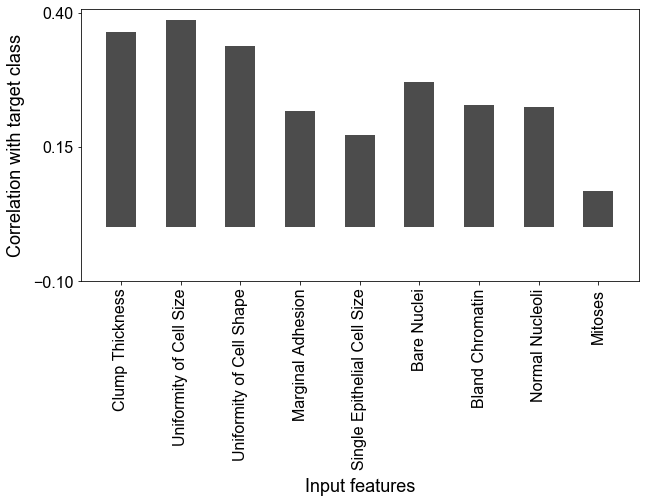

In [31]:
cols = df_cleaned_bc.columns
corr_with_class = np.zeros((len(cols[2:-1])))
features = []
for i,v in enumerate(cols[2:-1]): 
    corrs = np.corrcoef(df_cleaned_bc[v], df_cleaned_bc['Class'], rowvar=False)
    corr_with_class[i] = "%0.5f" %corrs[0][1]
    features.append(v)
plot_correlation_with_labels(corr_with_class, features)

### Correlation among the features
Some features showed strong correlation with each other such as __uniformity of cell size with uniformity of cell shape and normal nucleoli (red)__. Conversely, mitoses has strong anti-correlation with other features. 

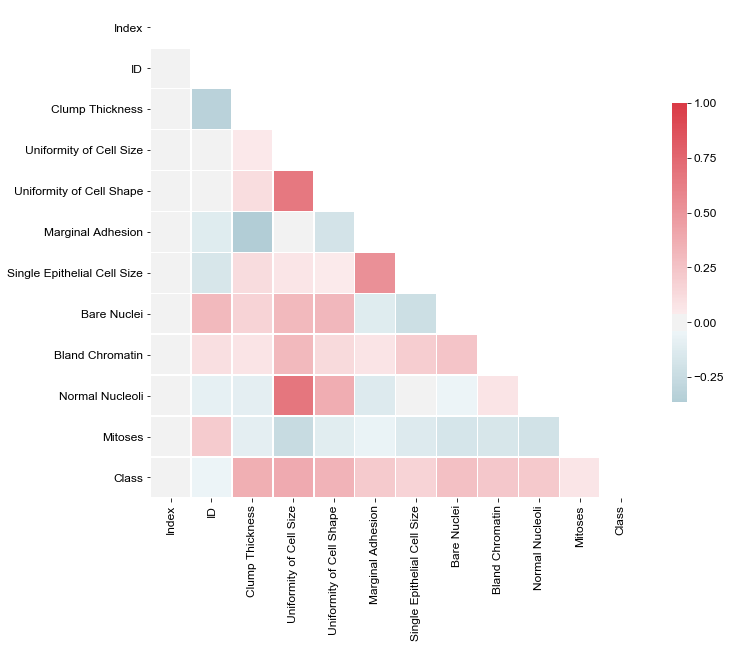

In [32]:
ar_corr_mat = df_cleaned_bc.corr()
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ar_mask = np.zeros_like(ar_corr_mat, dtype=np.bool)
ar_mask[np.triu_indices_from(ar_mask)] = True
params = {"shrink": .50}
sns.heatmap(ar_corr_mat, mask=ar_mask, cmap=cmap, vmax=1.0, 
            center=0, square=True, linewidths=.5, cbar_kws=params)
sns.set(font_scale=3)

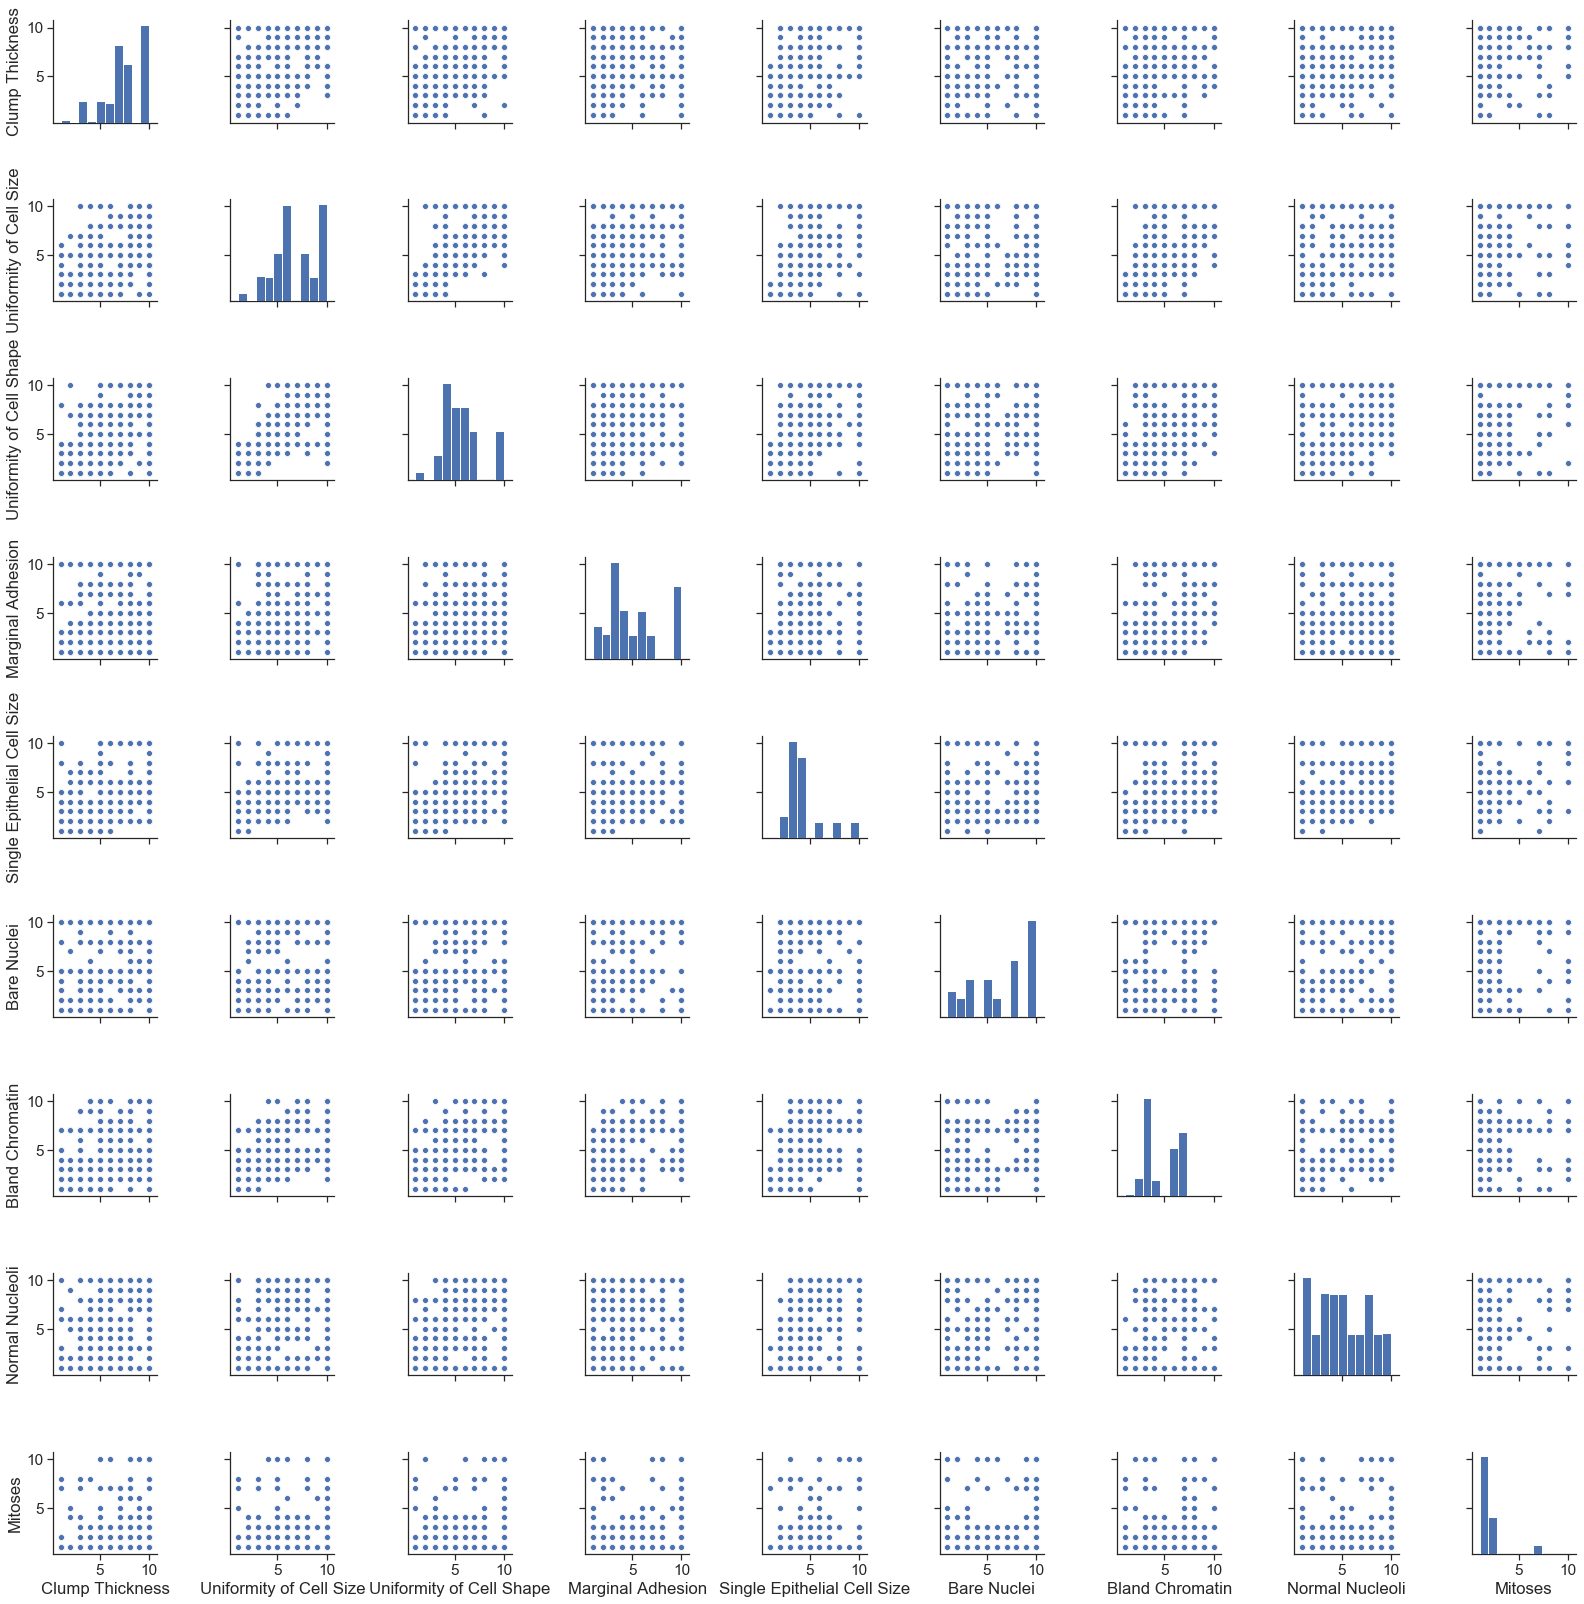

In [33]:
ls_selected_cols = df_cleaned_bc.columns[2:-1]
sns.set(style="ticks", color_codes=True, font_scale=1.4)
sns.pairplot(df_cleaned_bc[ls_selected_cols])

## Model preparation

### Target class distribution

Before moving for a model building, class distribution was analyzed. As shown by the following histogram, target class data is highly imbalance as malignant class (97%) completely dominates benign class (3%). 

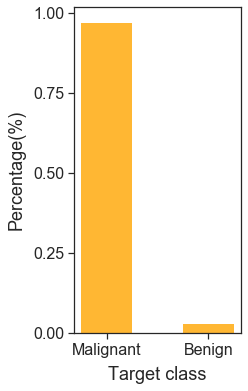

In [40]:
def plot_class_distribution(data, xlabels):
    fig  = plt.figure(figsize=(3, 6))
    ax    = fig.add_subplot(111)
    in_width = 0.5
    ar_idxes = np.arange(data.shape[0])
    p1=ax.bar(ar_idxes, data, in_width, color='orange', edgecolor='none', alpha=0.8)
    plt.xticks(ar_idxes, xlabels, fontsize=16, rotation=0)
    plt.yticks(np.arange(0.0, 1.05, 0.25), fontsize=16)
    ax.set_xlabel('Target class', axis_font, labelpad=8)
    ax.set_ylabel("Percentage(%)", axis_font, labelpad=8)
    plt.show()


unique_data = df_bc['Class'].value_counts(normalize=True)
xlabels = unique_data.keys().to_list()
xlabels = [ "Benign" if i==2 else "Malignant" for i in xlabels ]
data = np.array(unique_data.to_list())
plot_class_distribution(data, xlabels)

### Tree classifier
Due to categorical data, tree classifier is chosen. Nine properties of cell were copied to X and class is assigned to y.   

In [42]:
X = df_cleaned_bc[ls_selected_cols].values
y = df_cleaned_bc['Class'].values

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=9)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
tn, fp, fn, tp  = confusion_matrix(y_test, y_predict).ravel()
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)

print(tn, fp, fn, tp, tpr, fpr)
print("False positive rate: %0.5f" %fpr)
print("True positive rate: %0.5f" %tpr)

print("Recall: %0.8f" %(tp/(tp+fn)))
print("Precision: %0.8f" %(tp/(tp+fp)))

39 1 2 1519 0.9986850756081526 0.025
False positive rate: 0.02500
True positive rate: 0.99869
Recall: 0.99868508
Precision: 0.99934211


### How would a physician use your product?

In [55]:
y_predict = clf.predict(np.array([7, 3, 4, 4, 3, 3, 3, 2, 7]).reshape(-1,9))
print("Predicted target: %s " %"Malignant" if y_predict == 4 else "Benign")

Predicted target: Malignant 
